# Dobble Tutorial
# Part 3 - Training the Dobble Classifier with TF2 for DPU compilation

## Goal

In this notebook we show how to train a simple Convolutional Neural Network (CNN)
on the Dobble dataset for deployment on the DPU. We will cover:

* Loading and pre-processing the Dobble dataset
* Training a CNN with Tensorflow2
* Quantizing and evaluating the quantized model
* Compiling for DPU using the Vitis AI compiler


## References

* [Dobble Dataset](https://www.kaggle.com/grouby/dobble-card-images)
* [Dobble Challenge](https://avnet.me/dobble)
* [Training the Dobble Challenge](https://avnet.me/dobble-training)
* [Vitis AI v2.5](https://github.com/Xilinx/Vitis-AI/tree/v2.5)
* [DPU-PYNQ](https://github.com/Xilinx/DPU-PYNQ)


## Version History
* Jan 17, 2023
    * Preliminary revision

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

2023-01-17 13:43:17.042256: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/vitis_ai/conda/envs/vitis-ai-tensorflow2/lib/python3.7/site-packages/cv2/../../lib64:/opt/xilinx/xrt/lib:/usr/lib:/usr/lib/x86_64-linux-gnu
2023-01-17 13:43:17.042273: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow version: 2.8.0


## 1. Loading the dataset

The augmented Dobble dataset comes with 55k JPG (color) images of various sizes, organized in sub-folders corresponding to card decks.

```
├── deck01
│   ├── 00
│   ├── 01
│   ├── 02
│   ├── 03
│   ├── 04
│   ├── ...
│   └── 55
│   ...
└── deck09
    ├── 00
    ├── 01
    ├── 02
    ├── 03
    ├── 04
    ├── ...
    └── 55
```

We will use `image_dataset_from_directory()` to load the dataset for training with Keras.  

This API requires the image to be in PNG format, and in a slightly different directory structure.


### 1.1 Dataset Directory Structure
Let's take a look at how the images and folders are structured. This will be of particular importance when using 
`image_dataset_from_directory()`. There are two top-level directories called `train` and `test` and each of these contains subdirectories for each of the classes in the dataset. Each of the class subfolders in turn, contains the images for the respective classes. Not all datasets are conveniently split into train and test components.  For training, however, we will use `image_dataset_from_directory()` to further split the train data into training and validation components.

```
├── train
│   ├── 00
│   ├── 01
│   ├── 02
│   ├── 03
│   ├── 04
│   ├── ...
│   └── 55
└── test
    ├── 00
    ├── 01
    ├── 02
    ├── 03
    ├── 04
    ├── ...
    └── 55

```

In [2]:
nrows = 224
ncols = 224

nchannels = 3

In [3]:
#
# Capture images/labels from data set for training and testing
#

def capture_card_filenames(directory_name):
    subdirs = ['{}/{}'.format(directory_name,i) for i in os.listdir(directory_name) ]
    cards = []
    for i,subdir in enumerate(subdirs):
        cards += ['{}/{}'.format(subdir,i) for i in os.listdir(subdir)]
    del subdirs
    return cards



In [4]:
#
# Read images and pre-process to fixed size
#

def read_and_process_image(list_of_images):
    X = []
    y = []
    
    for i,image in enumerate(list_of_images):
        X.append(cv2.resize(cv2.imread(image,cv2.IMREAD_COLOR),(nrows,ncols), interpolation=cv2.INTER_CUBIC))
        y_str = image.split('/')
        y.append(int(y_str[len(y_str)-2]))
    return X,y




Next ...

In [5]:
input1_dir = './dobble-dataset'
input2_dir = './dobble-dataset-augmented'
output_dir = './dobble-dataset-keras'
train_dir = output_dir+'/train'

if not os.path.exists(output_dir):
    os.mkdir(output_dir)
if not os.path.exists(train_dir):
    os.mkdir(train_dir)

nchannels = 3

train_card_decks = [
    'dobble_deck01_cards_57',
    'dobble_deck02_cards_55',
    'dobble_deck03_cards_55',
    'dobble_deck04_cards_55',
    'dobble_deck05_cards_55',
    'dobble_deck06_cards_55',
    'dobble_deck07_cards_55',
    'dobble_deck08_cards_55',
    'dobble_deck09_cards_55',
    'dobble_deck10_cards_55'
    ]
nb_train_card_decks = len(train_card_decks)
print("Training Card Decks : ", nb_train_card_decks, train_card_decks)


#
# Capture images/labels from data set for training and testing
#

train_cards = []
for d in range(0,nb_train_card_decks):
    train_deck = input2_dir+'/'+train_card_decks[d]
    train_cards.append( capture_card_filenames(train_deck) )

#
# Read images, rename, and convert to png
#

for d in range(0,nb_train_card_decks):
   for i,image in enumerate(train_cards[d]):
      
      image_split = image.split('/')
      # ['.', 'dobble_dataset', 'dobble_deck10_cards_55', '55', 'card55_10.tif']
      deck_split = image_split[2].split('_')
      file_split = image_split[4].split('.')

      output_path = train_dir+'/'+image_split[3]
      if not os.path.exists(output_path):
         os.mkdir(output_path)
      
      image_dst = train_dir+'/'+image_split[3]+'/'+deck_split[1]+'.'+deck_split[1]+'_'+file_split[0]+'.png'
      if not os.path.exists(image_dst):
         cv2.imwrite(image_dst, cv2.imread(image,cv2.IMREAD_COLOR) )

      print( image, "=>", image_dst )




Training Card Decks :  10 ['dobble_deck01_cards_57', 'dobble_deck02_cards_55', 'dobble_deck03_cards_55', 'dobble_deck04_cards_55', 'dobble_deck05_cards_55', 'dobble_deck06_cards_55', 'dobble_deck07_cards_55', 'dobble_deck08_cards_55', 'dobble_deck09_cards_55', 'dobble_deck10_cards_55']
./dobble-dataset-augmented/dobble_deck01_cards_57/40/card40_041.tif => ./dobble-dataset-keras/train/40/deck01.deck01_card40_041.png
./dobble-dataset-augmented/dobble_deck01_cards_57/40/card40_022.tif => ./dobble-dataset-keras/train/40/deck01.deck01_card40_022.png
./dobble-dataset-augmented/dobble_deck01_cards_57/40/card40_007.tif => ./dobble-dataset-keras/train/40/deck01.deck01_card40_007.png
./dobble-dataset-augmented/dobble_deck01_cards_57/40/card40_052.tif => ./dobble-dataset-keras/train/40/deck01.deck01_card40_052.png
./dobble-dataset-augmented/dobble_deck01_cards_57/40/card40_016.tif => ./dobble-dataset-keras/train/40/deck01.deck01_card40_016.png
./dobble-dataset-augmented/dobble_deck01_cards_57/40/

./dobble-dataset-augmented/dobble_deck02_cards_55/28/card28_027.tif => ./dobble-dataset-keras/train/28/deck02.deck02_card28_027.png
./dobble-dataset-augmented/dobble_deck02_cards_55/28/card28_031.tif => ./dobble-dataset-keras/train/28/deck02.deck02_card28_031.png
./dobble-dataset-augmented/dobble_deck02_cards_55/28/card28_029.tif => ./dobble-dataset-keras/train/28/deck02.deck02_card28_029.png
./dobble-dataset-augmented/dobble_deck02_cards_55/28/card28_043.tif => ./dobble-dataset-keras/train/28/deck02.deck02_card28_043.png
./dobble-dataset-augmented/dobble_deck02_cards_55/28/card28_059.tif => ./dobble-dataset-keras/train/28/deck02.deck02_card28_059.png
./dobble-dataset-augmented/dobble_deck02_cards_55/28/card28_065.tif => ./dobble-dataset-keras/train/28/deck02.deck02_card28_065.png
./dobble-dataset-augmented/dobble_deck02_cards_55/28/card28_033.tif => ./dobble-dataset-keras/train/28/deck02.deck02_card28_033.png
./dobble-dataset-augmented/dobble_deck02_cards_55/28/card28_022.tif => ./dob

./dobble-dataset-augmented/dobble_deck02_cards_55/34/card34_031.tif => ./dobble-dataset-keras/train/34/deck02.deck02_card34_031.png
./dobble-dataset-augmented/dobble_deck02_cards_55/34/card34_040.tif => ./dobble-dataset-keras/train/34/deck02.deck02_card34_040.png
./dobble-dataset-augmented/dobble_deck02_cards_55/34/card34_014.tif => ./dobble-dataset-keras/train/34/deck02.deck02_card34_014.png
./dobble-dataset-augmented/dobble_deck02_cards_55/34/card34_001.tif => ./dobble-dataset-keras/train/34/deck02.deck02_card34_001.png
./dobble-dataset-augmented/dobble_deck02_cards_55/34/card34_042.tif => ./dobble-dataset-keras/train/34/deck02.deck02_card34_042.png
./dobble-dataset-augmented/dobble_deck02_cards_55/34/card34_055.tif => ./dobble-dataset-keras/train/34/deck02.deck02_card34_055.png
./dobble-dataset-augmented/dobble_deck02_cards_55/34/card34_045.tif => ./dobble-dataset-keras/train/34/deck02.deck02_card34_045.png
./dobble-dataset-augmented/dobble_deck02_cards_55/34/card34_039.tif => ./dob

./dobble-dataset-augmented/dobble_deck04_cards_55/19/card19_028.tif => ./dobble-dataset-keras/train/19/deck04.deck04_card19_028.png
./dobble-dataset-augmented/dobble_deck04_cards_55/19/card19_071.tif => ./dobble-dataset-keras/train/19/deck04.deck04_card19_071.png
./dobble-dataset-augmented/dobble_deck04_cards_55/19/card19_056.tif => ./dobble-dataset-keras/train/19/deck04.deck04_card19_056.png
./dobble-dataset-augmented/dobble_deck04_cards_55/19/card19_016.tif => ./dobble-dataset-keras/train/19/deck04.deck04_card19_016.png
./dobble-dataset-augmented/dobble_deck04_cards_55/19/card19_005.tif => ./dobble-dataset-keras/train/19/deck04.deck04_card19_005.png
./dobble-dataset-augmented/dobble_deck04_cards_55/19/card19_029.tif => ./dobble-dataset-keras/train/19/deck04.deck04_card19_029.png
./dobble-dataset-augmented/dobble_deck04_cards_55/19/card19_063.tif => ./dobble-dataset-keras/train/19/deck04.deck04_card19_063.png
./dobble-dataset-augmented/dobble_deck04_cards_55/19/card19_059.tif => ./dob

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [6]:
input1_dir = './dobble-dataset'
input2_dir = './dobble-dataset-augmented'
output_dir = './dobble-dataset-keras'
test_dir = output_dir+'/test'

if not os.path.exists(output_dir):
    os.mkdir(output_dir)
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

nchannels = 3

test_card_decks = [
    'dobble_deck01_cards_57',
    'dobble_test01_cards',
    'dobble_test02_cards'
    ]
nb_test_card_decks = len(test_card_decks)
print("Testing Card Decks : ", nb_test_card_decks, test_card_decks)

#
# Capture images/labels from data set for training and testing
#

test_cards = []
for d in range(0,nb_test_card_decks):
    test_deck = input1_dir+'/'+test_card_decks[d]
    test_cards.append( capture_card_filenames(test_deck) )

#
# Read images, rename, and convert to png
#

for d in range(0,nb_test_card_decks):
   for i,image in enumerate(test_cards[d]):
      
      image_split = image.split('/')
      # ['.', 'dobble_dataset', 'dobble_deck10_cards_55', '55', 'card55_10.tif']
      deck_split = image_split[2].split('_')
      file_split = image_split[4].split('.')
      
      output_path = test_dir+'/'+image_split[3]
      if not os.path.exists(output_path):
         os.mkdir(output_path)
      
      image_dst = test_dir+'/'+image_split[3]+'/'+deck_split[1]+'.'+deck_split[1]+'_'+file_split[0]+'.png'
      if not os.path.exists(image_dst):        
         cv2.imwrite(image_dst, cv2.imread(image,cv2.IMREAD_COLOR) )

      print( image, "=>", image_dst )


Testing Card Decks :  3 ['dobble_deck01_cards_57', 'dobble_test01_cards', 'dobble_test02_cards']
./dobble-dataset/dobble_deck01_cards_57/40/card40_01.tif => ./dobble-dataset-keras/test/40/deck01.deck01_card40_01.png
./dobble-dataset/dobble_deck01_cards_57/42/card42_01.tif => ./dobble-dataset-keras/test/42/deck01.deck01_card42_01.png
./dobble-dataset/dobble_deck01_cards_57/14/card14_01.tif => ./dobble-dataset-keras/test/14/deck01.deck01_card14_01.png
./dobble-dataset/dobble_deck01_cards_57/38/card38_01.tif => ./dobble-dataset-keras/test/38/deck01.deck01_card38_01.png
./dobble-dataset/dobble_deck01_cards_57/28/card28_01.tif => ./dobble-dataset-keras/test/28/deck01.deck01_card28_01.png
./dobble-dataset/dobble_deck01_cards_57/13/card13_01.tif => ./dobble-dataset-keras/test/13/deck01.deck01_card13_01.png
./dobble-dataset/dobble_deck01_cards_57/31/card31_01.tif => ./dobble-dataset-keras/test/31/deck01.deck01_card31_01.png
./dobble-dataset/dobble_deck01_cards_57/06/card06_01.tif => ./dobble-d

./dobble-dataset/dobble_test02_cards/29/card29_1522.tif => ./dobble-dataset-keras/test/29/test02.test02_card29_1522.png
./dobble-dataset/dobble_test02_cards/29/card29_1533.tif => ./dobble-dataset-keras/test/29/test02.test02_card29_1533.png
./dobble-dataset/dobble_test02_cards/29/card29_1532.tif => ./dobble-dataset-keras/test/29/test02.test02_card29_1532.png
./dobble-dataset/dobble_test02_cards/29/card29_1519.tif => ./dobble-dataset-keras/test/29/test02.test02_card29_1519.png
./dobble-dataset/dobble_test02_cards/29/card29_1527.tif => ./dobble-dataset-keras/test/29/test02.test02_card29_1527.png
./dobble-dataset/dobble_test02_cards/29/card29_1529.tif => ./dobble-dataset-keras/test/29/test02.test02_card29_1529.png
./dobble-dataset/dobble_test02_cards/29/card29_1537.tif => ./dobble-dataset-keras/test/29/test02.test02_card29_1537.png
./dobble-dataset/dobble_test02_cards/29/card29_1534.tif => ./dobble-dataset-keras/test/29/test02.test02_card29_1534.png
./dobble-dataset/dobble_test02_cards/29/

## 2. Training the model

Create a `tensorflow.keras.model` object by passing a list of layers. 
Because the Dobble dataset is moderately difficult, 
we will use a classic model architecture with four convolutional layers.

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import zipfile
import requests
import glob as glob

from tensorflow.keras.utils import image_dataset_from_directory

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass 

block_plot = False
plt.rcParams['figure.figsize'] = (12, 9) 
SEED_VALUE = 42 

### 2.1 Dataset and Training Configuration

In [8]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 58
    IMG_HEIGHT:  int = 224
    IMG_WIDTH:   int = 224
    CHANNELS:    int = 3
    BATCH_SIZE:  int = 32
    DATA_ROOT_TRAIN: str = './dobble-dataset-keras/train'
    DATA_ROOT_TEST: str = './dobble-dataset-keras/test'
        
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:     int   = 32
    EPOCHS:         int   = 39
    LEARNING_RATE:  float = 0.0001
    CHECKPOINT_DIR: str   = './dobble-03-checkpoints'

### 2.2 Prepare the Training, Validation, and Test Datasets

The Dobble dataset contains 10 card decks of 55-57 images, plus 2 additional sets of test images.

The 10 card decks, once augmented contain 55K images, which are used or training and validation, with a 80%/20% distribution.
The 2 test setsare  used after training to measure the final accuracy results with images from an actual card game.

In [9]:
train_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_TRAIN,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                             subset='training',
                                             validation_split=0.2
                                            )

valid_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_TRAIN,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                             subset='validation',
                                             validation_split=0.2
                                            )


Found 41550 files belonging to 58 classes.
Using 33240 files for training.


2023-01-17 13:43:21.963099: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/vitis_ai/conda/envs/vitis-ai-tensorflow2/lib/python3.7/site-packages/cv2/../../lib64:/opt/xilinx/xrt/lib:/usr/lib:/usr/lib/x86_64-linux-gnu
2023-01-17 13:43:21.963118: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-17 13:43:21.963135: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2023-01-17 13:43:21.963397: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler f

Found 41550 files belonging to 58 classes.
Using 8310 files for validation.


In [10]:

test_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_TEST,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                             )

Found 1336 files belonging to 58 classes.


### 2.3 Display Training Images

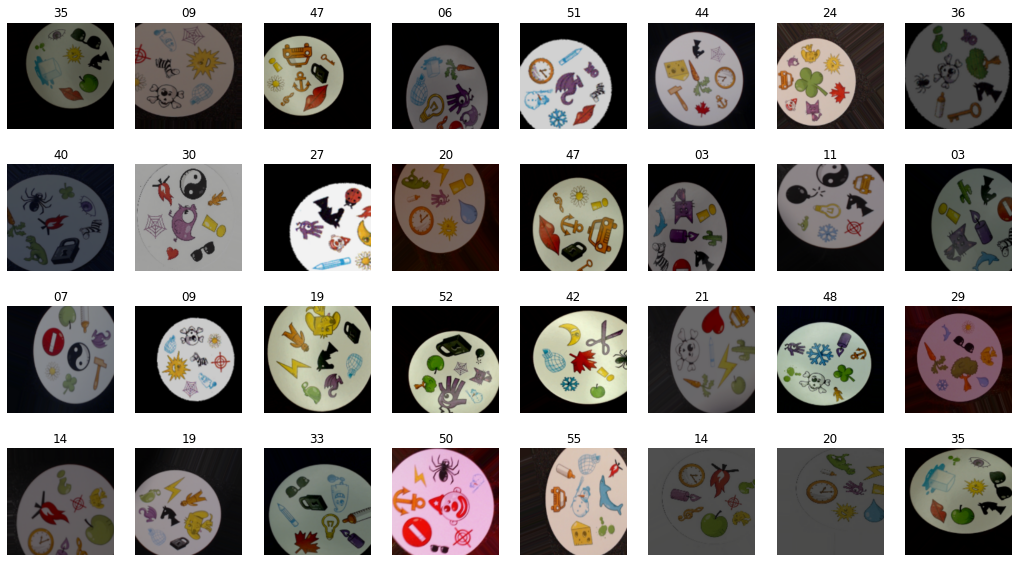

In [11]:
class_names = train_dataset.class_names

plt.figure(figsize=(18, 10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

# Here we use the take() method to retrieve just the first batch of data from the training portion of the dataset.
for image_batch, labels_batch in train_dataset.take(1): 
    
    # For the batch of images and the associated (one-hot encoded) labels, 
    # plot each of the images in the batch and the associated ground truth labels.
    for idx in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, idx + 1)
        plt.imshow(image_batch[idx].numpy().astype("uint8"))
        truth_idx = np.nonzero(labels_batch[idx].numpy())
        plt.title(class_names[truth_idx[0][0]])
        plt.axis("off")

### 2.4 Display Test Images

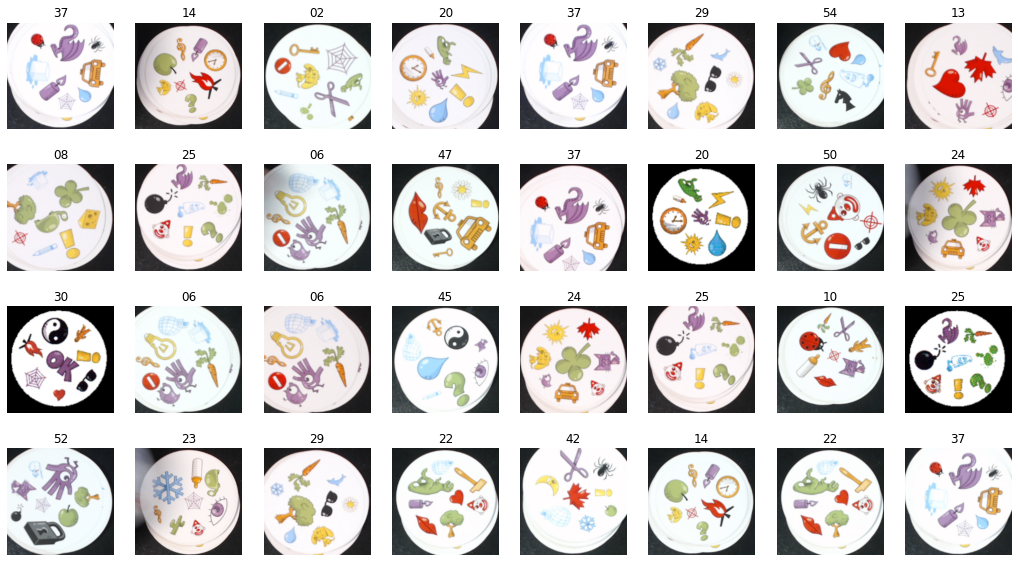

In [12]:
class_names = test_dataset.class_names

plt.figure(figsize=(18, 10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

# Here we use the take() method to retrieve just the first batch of data from the training portion of the dataset.
for image_batch, labels_batch in test_dataset.take(1): 
    
    # For the batch of images and the associated (one-hot encoded) labels, 
    # plot each of the images in the batch and the associated ground truth labels.
    for idx in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, idx + 1)
        plt.imshow(image_batch[idx].numpy().astype("uint8"))
        truth_idx = np.nonzero(labels_batch[idx].numpy())
        plt.title(class_names[truth_idx[0][0]])
        plt.axis("off")

### 2.5 Define the Model

In [13]:
inputs = tf.keras.Input(shape=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS))
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS))(inputs)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
outputs = tf.keras.layers.Dense(DatasetConfig.NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='dobble_classifier')
model.summary()

Model: "dobble_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128) 

### 2.6 Compile and Train the Model

Configure the model for training: choose desired optimizer, loss function
and metrics to observe over the training period.

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'],
                   )

In [15]:
# Save best model based on highest validation_accuracy.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=TrainingConfig.CHECKPOINT_DIR,
                                                               save_weights_only=False,
                                                               monitor='val_accuracy',
                                                               mode='max',
                                                               save_best_only=True,
                                                              )

Now we can train the model.

In [16]:
from datetime import datetime

# datetime object containing current date and time
print(datetime.now())

2023-01-17 13:43:27.874144


In [17]:
# Train the Model.
training_results = model.fit(train_dataset,
                                   validation_data=valid_dataset,
                                   epochs=TrainingConfig.EPOCHS,
                                   workers=4,
                                   use_multiprocessing=True, 
                                   callbacks=model_checkpoint_callback,
                                  )

Epoch 1/39
1039/1039 [==============================] - ETA: 0s - loss: 4.1942 - accuracy: 0.0446

2023-01-17 13:55:54.178027: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./dobble-03-checkpoints/assets
1039/1039 [==============================] - 749s 720ms/step - loss: 4.1942 - accuracy: 0.0446 - val_loss: 3.4783 - val_accuracy: 0.1247
Epoch 2/39
1039/1039 [==============================] - 737s 709ms/step - loss: 2.5719 - accuracy: 0.3047 - val_loss: 1.3756 - val_accuracy: 0.6239
Epoch 3/39
1039/1039 [==============================] - 739s 711ms/step - loss: 0.9371 - accuracy: 0.7279 - val_loss: 0.4253 - val_accuracy: 0.8838
Epoch 4/39
1039/1039 [==============================] - 745s 717ms/step - loss: 0.3596 - accuracy: 0.8925 - val_loss: 0.2703 - val_accuracy: 0.9203
Epoch 5/39
1039/1039 [==============================] - 750s 722ms/step - loss: 0.2022 - accuracy: 0.9397 - val_loss: 0.1355 - val_accuracy: 0.9622
Epoch 6/39
1039/1039 [==============================] - 749s 721ms/step - loss: 0.1315 - accuracy: 0.9622 - val_loss: 0.1598 - val_accuracy: 0.9538
Epoch 7/39
1039/1039 [==============================] - 7

Epoch 39/39
1039/1039 [==============================] - 764s 735ms/step - loss: 0.0091 - accuracy: 0.9976 - val_loss: 0.0294 - val_accuracy: 0.9937


In [18]:
# datetime object containing current date and time
print(datetime.now())

2023-01-17 21:57:28.999586


### 2.7 Plot the Training Results

We can inspect the training results by plotting the collected data in the
`training_results` object.

In [19]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
        
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show(block=block_plot)
    plt.close()

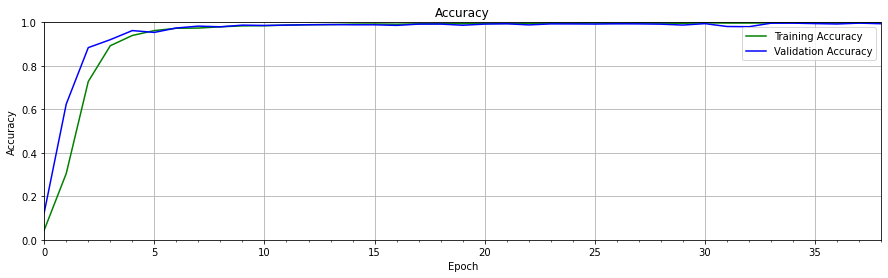

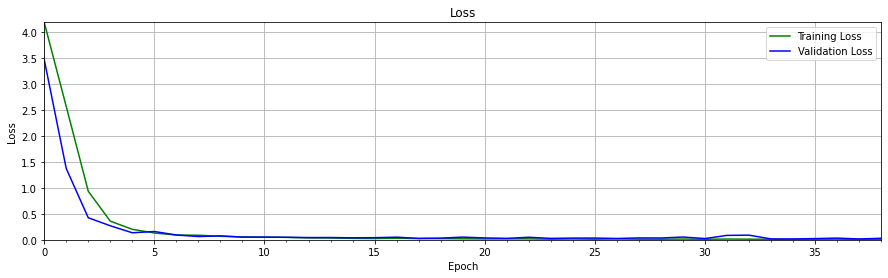

In [20]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]
    
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])
 
max_loss = max(max(train_loss), max(valid_loss))

plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, max_loss],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

### 2.8 Model Evaluation 

Evaluate the trained model on the test dataset.

In [21]:
# Load saved model.
# Final evaluation accuracy on the validation set.
model = tf.keras.models.load_model(TrainingConfig.CHECKPOINT_DIR)
print(f"Model evaluation accuracy: {model.evaluate(valid_dataset)[1]*100.:.3f}")

260/260 [==============================] - 43s 164ms/step - loss: 0.0158 - accuracy: 0.9965
Model evaluation accuracy: 99.651


In [22]:
# Final evaluation accuracy on the testing set.
model = tf.keras.models.load_model(TrainingConfig.CHECKPOINT_DIR)
print(f"Model testing accuracy: {model.evaluate(test_dataset)[1]*100.:.3f}")

42/42 [==============================] - 7s 173ms/step - loss: 0.2070 - accuracy: 0.9955
Model testing accuracy: 99.551


In [23]:
def display_wrong_predictions(dataset, checkpoint_dir=None, checkpoint_version=0):
    
    if not checkpoint_dir:
        checkpoint_dir = os.path.join(os.getcwd(), TrainingConfig.checkpoint_dir, f"version_{checkpoint_version}")
        
    # Load saved model.
    model = keras.models.load_model(checkpoint_dir)
    
    plt.figure(figsize=(20, 15))
    num_rows = 4
    num_cols = 5
    class_names = dataset.class_names
    jdx = 0
    
    # Evaluate all the batches.
    for image_batch, labels_batch in dataset:
        
        # Predictions for the current batch.
        predictions = model.predict(image_batch)
        
        # Loop over all the images in the current batch.
        for idx in range(len(labels_batch)):
            
            pred_idx = tf.argmax(predictions[idx]).numpy()
            truth_idx = np.nonzero(labels_batch[idx].numpy())
            
            # Plot the images with incorrect predictions
            if pred_idx != truth_idx:
                
                jdx += 1
                
                if jdx > num_rows*num_cols:
                    # Break from the loops if the maximum number of images have been plotted
                    break
                
                ax = plt.subplot(num_rows, num_cols, jdx)
                title = str(class_names[truth_idx[0][0]]) + " : " + str(class_names[pred_idx])
                title_obj = plt.title(title)
                plt.setp(title_obj, color='r')
                plt.axis("off")
                plt.imshow(image_batch[idx].numpy().astype("uint8"))
    return 

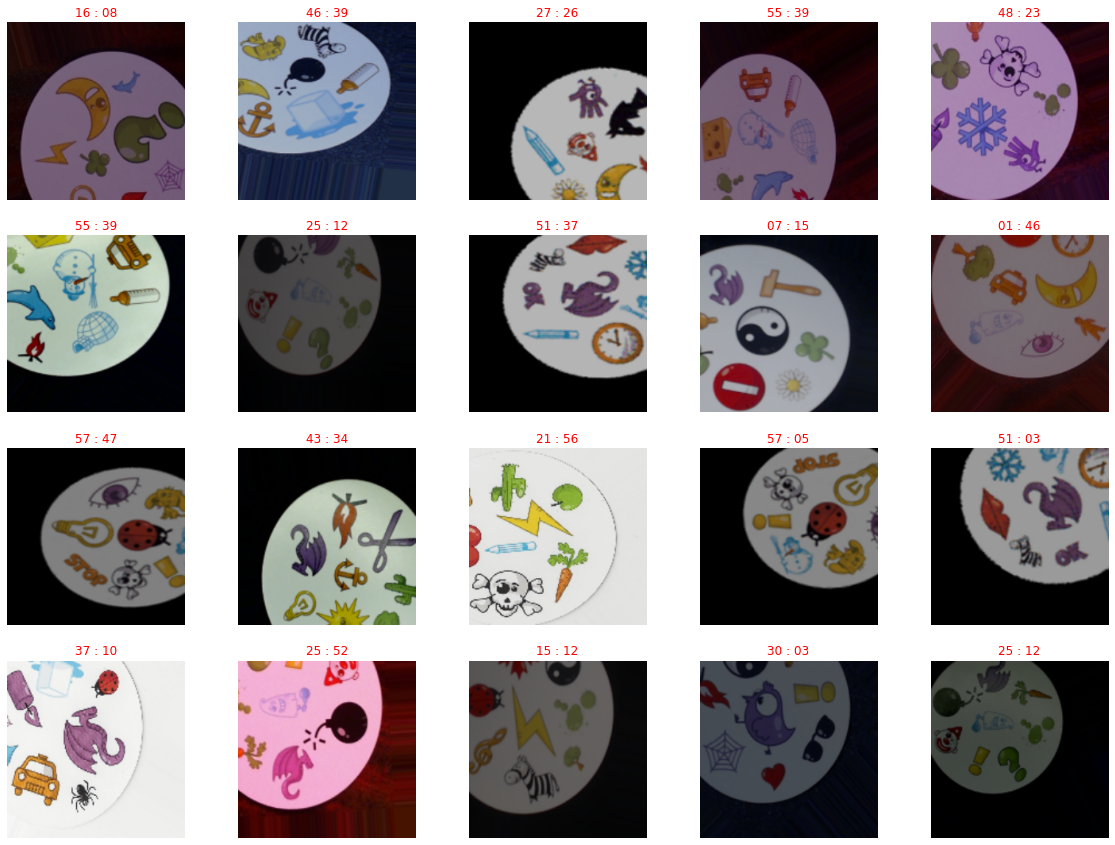

In [24]:
display_wrong_predictions(valid_dataset, TrainingConfig.CHECKPOINT_DIR)

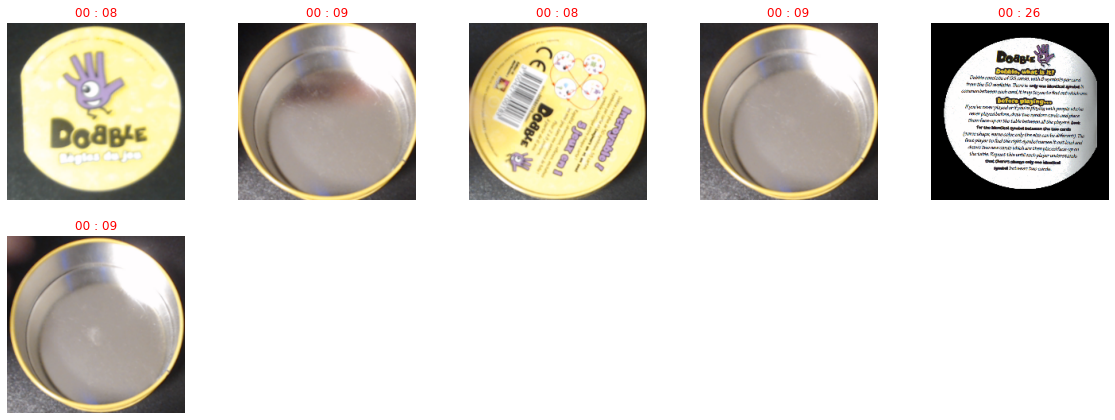

In [25]:
display_wrong_predictions(test_dataset, TrainingConfig.CHECKPOINT_DIR)

Currently the entire model graph is saved as a set of weights in floating point precision. We can make sure of that by printing out the dtype of one of the layers.

In [26]:
model.get_weights()[0].dtype

dtype('float32')

## 3. Quantization
In order to compile the trained model for deployment on a DPU platform, we must first quantize it. Here we will use the `vitis_quantize` module to convert the floating point model into an INT8 quantized representation. 

In [27]:
from tensorflow_model_optimization.quantization.keras import vitis_quantize

**Quantize model**

By default the `quantize_model` function converts the weights, activations and inputs into 8-bit wide numbers. We can specify different values and configurations using `weight_bit`, `activation_bit` and other parameters. 

In [29]:
quantizer = vitis_quantize.VitisQuantizer(model)
quantized_model = quantizer.quantize_model(calib_dataset=test_dataset, weight_bit=8, activation_bit=8)

[VAI INFO] Update activation_bit: 8
[VAI INFO] Update weight_bit: 8
[VAI INFO] Start CrossLayerEqualization...
10/10 [==============================] - 1s 136ms/step
[VAI INFO] CrossLayerEqualization Done.
[VAI INFO] Start Quantize Calibration...
42/42 [==============================] - 53s 1s/step
[VAI INFO] Quantize Calibration Done.
[VAI INFO] Start Post-Quant Model Refinement...
[VAI INFO] Start Quantize Position Ajustment...
[VAI INFO] Quantize Position Ajustment Done.
[VAI INFO] Post-Quant Model Refninement Done.
[VAI INFO] Start Model Finalization...
[VAI INFO] Model Finalization Done.
[VAI INFO] Quantization Finished.


**Evaluate quantized model**

In order to evaluate the quantized model, it needs to be re-compiled with the desired loss and evaluation metrics, such as accuracy. Since we are using 8-bit quantization we do not lose much performance, if at all.

In [32]:
quantized_model.compile(loss='categorical_crossentropy', metrics=["accuracy"])
print(f"Model evaluation accuracy: {quantized_model.evaluate(valid_dataset)[1]*100.:.3f}")

260/260 [==============================] - 73s 277ms/step - loss: 0.0177 - accuracy: 0.9958
Model evaluation accuracy: 99.579


In [33]:
print(f"Model evaluation accuracy: {quantized_model.evaluate(test_dataset)[1]*100.:.3f}")

42/42 [==============================] - 12s 277ms/step - loss: 0.2053 - accuracy: 0.9955
Model evaluation accuracy: 99.551


**Save quantized model**

Once we are happy with the performance of the quantized model, we can save it as a .h5 file, simply using the `save` method.

In [34]:
quantized_model.save('tf2_dobble_classifier_quantized.h5')

## 4. Compilation

For this final step we use the Vitis AI compiler `vai_c_tensorflow2` and pass the quantized model as a parameter. In this example we are compiling the DPU model targeting the KV260 board, however to target a different board you will just have to point the compiler to the right `arch.json` file. 

For example, for the ZCU104 you would pass

`--arch /opt/vitis_ai/compiler/arch/DPUCZDX8G/ZCU104/arch.json`

and for Ultra96, we can pass the custom arch.json in this repository

`--arch ./arch.json`

In [36]:
!vai_c_tensorflow2 \
    --model ./tf2_dobble_classifier_quantized.h5 \
    --arch ./model/B4096/arch-zcu104.json \
    --output_dir ./model/B4096/ \
    --net_name dobble_classifier

!vai_c_tensorflow2 \
    --model ./tf2_dobble_classifier_quantized.h5 \
    --arch ./model/B3136/arch-kv260.json \
    --output_dir ./model/B3136/ \
    --net_name dobble_classifier

!vai_c_tensorflow2 \
    --model ./tf2_dobble_classifier_quantized.h5 \
    --arch ./model/B2304/arch-b2304-lr.json \
    --output_dir ./model/B2304/ \
    --net_name dobble_classifier

!vai_c_tensorflow2 \
    --model ./tf2_dobble_classifier_quantized.h5 \
    --arch ./model/B1152/arch-b1152-hr.json \
    --output_dir ./model/B1152/ \
    --net_name dobble_classifier

!vai_c_tensorflow2 \
    --model ./tf2_dobble_classifier_quantized.h5 \
    --arch ./model/B512/arch-b512-lr.json \
    --output_dir ./model/B512/ \
    --net_name dobble_classifier

!vai_c_tensorflow2 \
    --model ./tf2_dobble_classifier_quantized.h5 \
    --arch ./model/B128/arch-b128-lr.json \
    --output_dir ./model/B128/ \
    --net_name dobble_classifier


**************************************************
* VITIS_AI Compilation - Xilinx Inc.
**************************************************
[INFO] Namespace(batchsize=1, inputs_shape=None, layout='NHWC', model_files=['./tf2_dobble_classifier_quantized.h5'], model_type='tensorflow2', named_inputs_shape=None, out_filename='/tmp/dobble_classifier_DPUCZDX8G_ISA1_B4096_org.xmodel', proto=None)
[INFO] tensorflow2 model: /workspace/tf2_dobble_classifier_quantized.h5
[INFO] keras version: 2.8.0
[INFO] Tensorflow Keras model type: functional
[INFO] generate xmodel     :100%|█| 33/33 [00:00<00:00, 54.08it/s]              
[INFO] dump xmodel: /tmp/dobble_classifier_DPUCZDX8G_ISA1_B4096_org.xmodel
[UNILOG][INFO] Compile mode: dpu
[UNILOG][INFO] Debug mode: function
[UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
[UNILOG][INFO] Graph name: dobble_classifier, with op num: 53
[UNILOG][INFO] Begin to compile...
[UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
[UNILOG][INFO]

[UNILOG][INFO] Total device subgraph number 5, DPU subgraph number 2
[UNILOG][INFO] Compile done.
[UNILOG][INFO] The meta json is saved to "/workspace/./model/B512/meta.json"
[UNILOG][INFO] The compiled xmodel is saved to "/workspace/./model/B512//dobble_classifier.xmodel"
[UNILOG][INFO] The compiled xmodel's md5sum is 7de163b978e8fdaecc8fc573872b2355, and has been saved to "/workspace/./model/B512/md5sum.txt"
**************************************************
* VITIS_AI Compilation - Xilinx Inc.
**************************************************
[INFO] Namespace(batchsize=1, inputs_shape=None, layout='NHWC', model_files=['./tf2_dobble_classifier_quantized.h5'], model_type='tensorflow2', named_inputs_shape=None, out_filename='/tmp/dobble_classifier_0x101000002010208_org.xmodel', proto=None)
[INFO] tensorflow2 model: /workspace/tf2_dobble_classifier_quantized.h5
[INFO] keras version: 2.8.0
[INFO] Tensorflow Keras model type: functional
[INFO] generate xmodel     :100%|█| 33/33 [00:00<00

----

Copyright (C) 2023 Avnet, Inc

SPDX-License-Identifier: Apache-2.0 License

----

----